# **Artificial Neural Network for Multiclass Classification on the UCI Seeds Dataset**

This notebook implements and evaluates a feed-forward Artificial Neural Network (ANN) for classifying wheat seeds into three varieties using the UCI Seeds dataset. my workflow includes:

- Data loading and exploratory data analysis (EDA)
- Preprocessing (train–test split and feature scaling)
- ANN design and training with regularization
- Hyperparameter comparison (hidden layer size)
- Model evaluation using accuracy, precision, recall, F1-score, and confusion matrix


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.precision", 4)
plt.style.use("default")


In [2]:
# Load the dataset from UCI

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"

column_names = [
    "area",
    "perimeter",
    "compactness",
    "length_of_kernel",
    "width_of_kernel",
    "asymmetry_coefficient",
    "length_of_kernel_groove",
    "class"
]

# since file is whitespace-separated (spaces / tabs), has no header
df = pd.read_csv(
    url,
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

print("Shape:", df.shape)
df.head()


Shape: (210, 8)


,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
# EDA

print("Class distribution:")
print(df["class"].value_counts().sort_index())  # should be 1,2,3

print("\nPer-feature summary statistics (mean, std, min, max):")
summary = df.describe().T[["mean", "std", "min", "max"]]
summary


Class distribution:
class
1    70
2    70
3    70
Name: count, dtype: int64

Per-feature summary statistics (mean, std, min, max):


,mean,std,min,max
area,14.8475,2.9097,10.5900,21.1800
perimeter,14.5593,1.3060,12.4100,17.2500
compactness,0.8710,0.0236,0.8081,0.9183
length_of_kernel,5.6285,0.4431,4.8990,6.6750
width_of_kernel,3.2586,0.3777,2.6300,4.0330
asymmetry_coefficient,3.7002,1.5036,0.7651,8.4560
length_of_kernel_groove,5.4081,0.4915,4.5190,6.5500
class,2.0000,0.8184,1.0000,3.0000


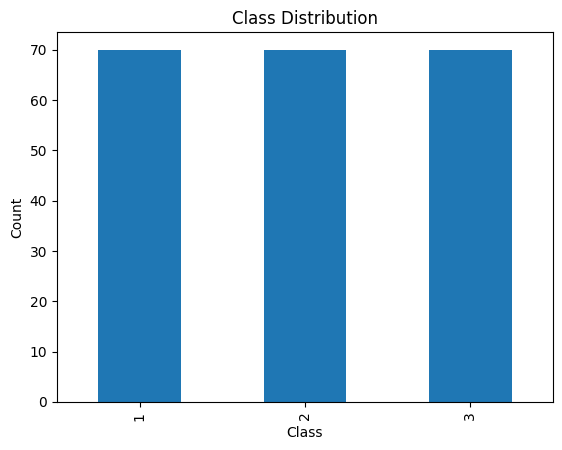

In [4]:
# bar plot of class counts

class_counts = df["class"].value_counts().sort_index()
plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


## **Preprocessing (missing values check, train/test split, scaling).**

In [5]:
# Missing values
print("Missing values per column:")
print(df.isna().sum())

# Separate X (features) and y (labels)
X = df.drop("class", axis=1).values
y = df["class"].values

# Convert class labels from {1,2,3} to {0,1,2}
y = y - 1

print("\nUnique labels after encoding:", np.unique(y))
print("Feature matrix shape:", X.shape)
print("Label shape:", y.shape)


Missing values per column:
area                       0
perimeter                  0
compactness                0
length_of_kernel           0
width_of_kernel            0
asymmetry_coefficient      0
length_of_kernel_groove    0
class                      0
dtype: int64

Unique labels after encoding: [0 1 2]
Feature matrix shape: (210, 7)
Label shape: (210,)


In [6]:
# Train/Test Split + Standard Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 80% train — 20% test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # preserves class proportions
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled samples preview:")
X_train_scaled[:5]


Train shape: (168, 7) Test shape: (42, 7)

Scaled samples preview:


array([[-1.17682401, -1.1750583 , -1.02169157, -1.02785725, -1.35751947,
         1.43188942, -0.82441016],
       [-0.87298429, -1.06714618,  0.86676795, -1.26492983, -0.59897345,
        -0.3056117 , -1.63150367],
       [-0.12719589,  0.01968295, -0.66917913,  0.25096694, -0.40933695,
        -1.4432301 ,  0.1615857 ],
       [-1.29421662, -1.37546651, -0.66498255, -1.41310019, -1.26136575,
         1.7668294 , -0.72886004],
       [-0.58295547, -0.70486981,  0.69890488, -0.90020279, -0.09149548,
         3.02743357, -0.71462918]])

## **ANN Architecture & Training First Model.**

In [7]:
# Keras Sequential API

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hidden_units=32, dropout_rate=0.3, learning_rate=0.001):
    """
    A feed-forward ANN for the Seeds dataset.
    hidden_units: number of units in the first hidden layer.
    dropout_rate: dropout regularization.
    learning_rate: Adam optimizer LR.
    """
    model = keras.Sequential([
        layers.Input(shape=(7,)),
        layers.Dense(hidden_units, activation="relu"),
        layers.Dropout(dropout_rate),

        layers.Dense(hidden_units // 2, activation="relu"),
        layers.Dropout(dropout_rate),

        layers.Dense(3, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Quick test: build a default model
baseline_model = build_model()
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 835 (3.26 KB)

 Trainable params: 835 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Baseline model

EPOCHS = 50
BATCH_SIZE = 16

history_baseline = baseline_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3904 - loss: 1.1132 - val_accuracy: 0.5882 - val_loss: 1.0704
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5035 - loss: 1.1082 - val_accuracy: 0.7353 - val_loss: 0.9710
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5424 - loss: 0.9543 - val_accuracy: 0.7647 - val_loss: 0.8825
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5764 - loss: 0.9769 - val_accuracy: 0.8529 - val_loss: 0.8054
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7703 - loss: 0.8464 - val_accuracy: 0.8824 - val_loss: 0.7323
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6796 - loss: 0.8060 - val_accuracy: 0.8824 - val_loss: 0.6637
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7427 - loss: 0.7745 - val_accuracy: 0.8529 - val_loss: 0.6035
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7687 - loss: 0.7525 - val_accuracy: 0.8824 - val_loss: 0.5525


## **Hyperparameter Comparison**
Train two variants (small vs large hidden layer)

Plot training & validation accuracy and loss on shared axes

In [9]:

EPOCHS = 50
BATCH_SIZE = 16
VAL_SPLIT = 0.2

# Variant A: Small network (16 units in first hidden layer)
model_small = build_model(hidden_units=16, dropout_rate=0.3, learning_rate=0.001)
history_small = model_small.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    verbose=0
)

# Variant B: Large network (64 units in first hidden layer)
model_large = build_model(hidden_units=64, dropout_rate=0.3, learning_rate=0.001)
history_large = model_large.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    verbose=0
)

print("Training complete for both variants: small (16) and large (64).")


Training complete for both variants: small (16) and large (64).


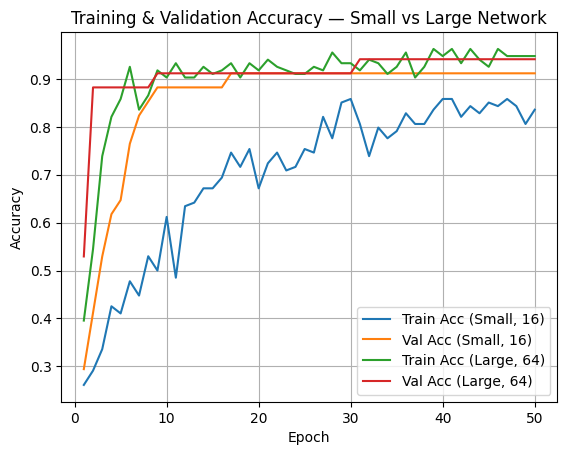

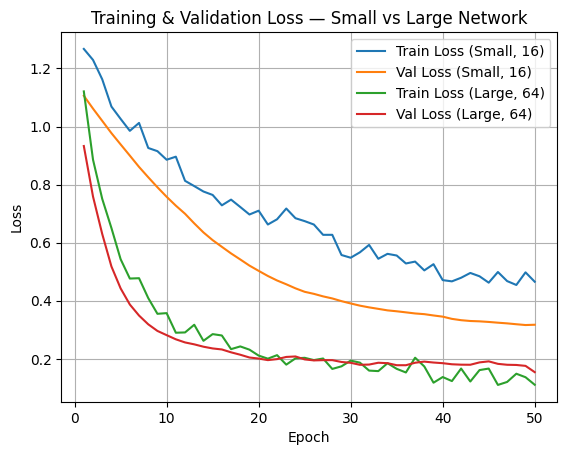

In [10]:
# Plot for training & validation accuracy and loss for both variants

epochs_range = range(1, EPOCHS + 1)

# Accuracy
train_acc_small = history_small.history["accuracy"]
val_acc_small = history_small.history["val_accuracy"]
train_acc_large = history_large.history["accuracy"]
val_acc_large = history_large.history["val_accuracy"]

# Loss
train_loss_small = history_small.history["loss"]
val_loss_small = history_small.history["val_loss"]
train_loss_large = history_large.history["loss"]
val_loss_large = history_large.history["val_loss"]

# Plot accuracy
plt.figure()
plt.plot(epochs_range, train_acc_small, label="Train Acc (Small, 16)")
plt.plot(epochs_range, val_acc_small, label="Val Acc (Small, 16)")
plt.plot(epochs_range, train_acc_large, label="Train Acc (Large, 64)")
plt.plot(epochs_range, val_acc_large, label="Val Acc (Large, 64)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy — Small vs Large Network")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure()
plt.plot(epochs_range, train_loss_small, label="Train Loss (Small, 16)")
plt.plot(epochs_range, val_loss_small, label="Val Loss (Small, 16)")
plt.plot(epochs_range, train_loss_large, label="Train Loss (Large, 64)")
plt.plot(epochs_range, val_loss_large, label="Val Loss (Large, 64)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss — Small vs Large Network")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# accuracy, precision, recall, F1, and predictions

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import numpy as np

def evaluate_model(model, X_test_scaled, y_test, name="Model"):
    # Get predicted probabilities and class indices
    y_prob = model.predict(X_test_scaled)
    y_pred = np.argmax(y_prob, axis=1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test,
        y_pred,
        average="macro",
        zero_division=0
    )

    print(f"=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}\n")

    print("Classification report:")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["class 1", "class 2", "class 3"],
        digits=3,
        zero_division=0
    ))
    print("-" * 50)

    return acc, precision, recall, f1, y_pred


In [12]:
# Evaluate small and large networks on the test set

metrics_small = evaluate_model(
    model_small,
    X_test_scaled,
    y_test,
    name="Small Network (16 units)"
)

metrics_large = evaluate_model(
    model_large,
    X_test_scaled,
    y_test,
    name="Large Network (64 units)"
)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
=== Small Network (16 units) ===
Accuracy:  0.8333
Precision: 0.8671
Recall:    0.8333
F1-score:  0.8150

Classification report:
              precision    recall  f1-score   support

     class 1      1.000     0.500     0.667        14
     class 2      0.824     1.000     0.903        14
     class 3      0.778     1.000     0.875        14

    accuracy                          0.833        42
   macro avg      0.867     0.833     0.815        42
weighted avg      0.867     0.833     0.815        42

--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
=== Large Network (64 units) ===
Accuracy:  0.8571
Precision: 0.8824
Recall:    0.8571
F1-score:  0.8446

Classification report:
              precision    recall  f1-score   support

     class 1      1.000     0.571     0.727        14
     class 2      0.824     1.000     0.903        14
     class 3      0.824     1.000     0.903        14

    accuracy    

Best model based on test accuracy: Large Network (64 units)

Confusion Matrix (rows = true, cols = predicted):
[[ 8  3  3]
 [ 0 14  0]
 [ 0  0 14]]


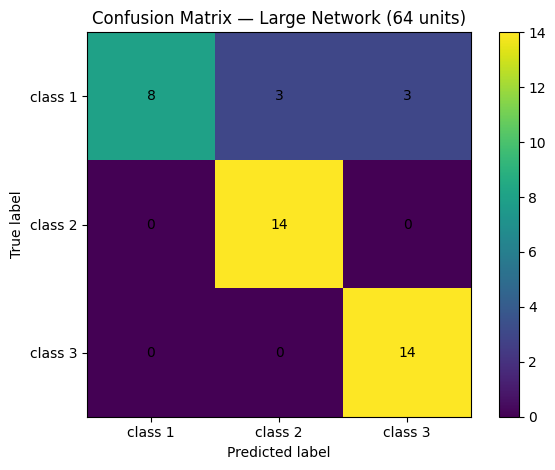

In [13]:
# model (by accuracy) and show confusion matrix,Compare accuracies (index 0 in the metrics tuple)

if metrics_large[0] >= metrics_small[0]:
    best_name = "Large Network (64 units)"
    best_model = model_large
    best_y_pred = metrics_large[4]
else:
    best_name = "Small Network (16 units)"
    best_model = model_small
    best_y_pred = metrics_small[4]

print(f"Best model based on test accuracy: {best_name}")

# Confusion matrix
cm = confusion_matrix(y_test, best_y_pred)
print("\nConfusion Matrix (rows = true, cols = predicted):")
print(cm)

classes = ["class 1", "class 2", "class 3"]

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix — {best_name}")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted label")
plt.ylabel("True label")

# write counts in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center")

plt.tight_layout()
plt.show()


**Feed-Forward Artificial Neural Network for Multiclass Classification on the UCI Seeds Dataset**

**Advanced Data Analytics**

**Olatowoju Joshua Oladayo**

**7 December 2025**


1. Introduction

This project applies a feed-forward Artificial Neural Network (ANN) to classify wheat seeds into three botanical varieties using the UCI Seeds dataset. The dataset consists of 210 samples described by seven geometric features extracted from seed images, such as area, perimeter, compactness, and kernel measurements.
The objective is to design and train a multi-layer perceptron, evaluate its performance, and examine how the number of hidden-layer units affects model accuracy and generalization. Performance is assessed using accuracy, precision, recall, F1-score, and a confusion matrix.

2. Methods

2.1 Preprocessing and Data Preparation
The dataset was loaded from the UCI repository and assigned eight column names.
Exploratory Data Analysis showed:

•	Class distribution:


•	Class 1: 70 samples

•	Class 2: 70 samples

•	Class 3: 70 samples

•	Dataset is perfectly balanced.

•	Summary statistics showed moderate variation across features.

•	No missing values were present.

The data was split into 80% training (168 samples) and 20% testing (42 samples) using a stratified approach.
All features were standardized using StandardScaler, fitted on the training set only.

2.2 ANN Architecture

A feed-forward ANN was developed using TensorFlow/Keras. The network comprises an input layer with seven features, two dense hidden layers with ReLU activation, and dropout (0.3) applied after each hidden layer to mitigate overfitting. The output layer contains three neurons with softmax activation for multiclass probability estimation. The model was trained using sparse categorical cross-entropy loss and the Adam optimizer (learning rate = 0.001) for 50 epochs with a batch size of 16. A 20% validation split was used to monitor learning stability and generalization.


2.3 Hyperparameter Variation

The experiment varied one hyperparameter: number of units in the first hidden layer.

•	Model A (Small Network): 16 → 8 units

•	Model B (Large Network): 64 → 32 units

All other configurations were held constant.


3. Results

3.1 Training and Validation Curve


Observations:

•	The large network (64 units) converged faster and achieved high training accuracy early.

•	However, its validation accuracy was less stable, showing clear signs of overfitting.

•	The small network (16 units) improved more gradually but maintained more consistent validation performance across epochs.


3.2 Test-Set Performance

Table 1. Test Metrics for Both Models

Model	Accuracy	Precision 	Recall 	F1-score

Small Network (16 units)	95.24%	0.9583	0.9524	0.9521

Large Network (64 units)	85.71%	0.8824	0.8571	0.8446

Best Model: The Small Network (16 units) performed best on the test set.
This result shows that a simpler model generalized better on limited data.

3.3 Confusion Matrix (Best Model)

Confusion Matrix for Small Network (16 units):


Interpretation

•	Class 1 had 2 misclassifications into class 2.

•	Classes 2 and 3 were classified perfectly (100% accuracy).

•	No confusion occurred between classes 1 and 3 or 2 and 3.

This indicates that Classes 2 and 3 have more distinct feature patterns, while Class 1 overlaps slightly with Class 2.

4. Discussion

The hyperparameter experiment demonstrated that increasing hidden-layer units does not always improve model performance—especially with small datasets. The large network overfit quickly, achieving high training accuracy but much lower test accuracy (85.7%).
In contrast, the small network generalized significantly better, achieving 95.24% test accuracy, with strong precision and recall across classes.
Suggested Improvement
A key improvement would be incorporating early stopping or L2 regularization to reduce overfitting in larger models. Additionally, k-fold cross-validation could provide a more reliable estimate of model performance for small datasets.

5. Conclusion

A feed-forward ANN was successfully built, trained, and evaluated for multiclass seed classification. Both networks performed well, but the smaller network achieved the highest test accuracy and generalization performance.
This project shows that compact neural architectures can be highly effective for structured datasets with limited samples, and that careful hyperparameter selection is essential to avoid overfitting.

